In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import yaml
import shap
import src.dax_utils as utils

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.options.display.float_format = '{:.5f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

Load Artifacts

In [3]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [4]:
with open('../config/config.yaml', 'r') as file:
    data_loaded = yaml.safe_load(file)

In [5]:
price = pd.read_csv('../db/raw.csv', index_col=0, header=[0,1], parse_dates=[0])
price_data = price.loc[:, pd.IndexSlice[['Open', 'Close'], ['^GDAXI']]]
# price_data.columns = ['gdaxi']
price_data.columns = ['open', 'close']

In [6]:
data_loaded.keys()

dict_keys(['selected_features', 'threshold', 'xgb_classifier_params'])

Train model

In [7]:
model = xgb.XGBClassifier(**data_loaded['xgb_classifier_params'], random_state=42)

In [8]:
model.fit(X_train[data_loaded['selected_features']], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9349900034477954, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06190619805741621,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014997010109161955,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=935, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Simplistic Backtest

<Axes: >

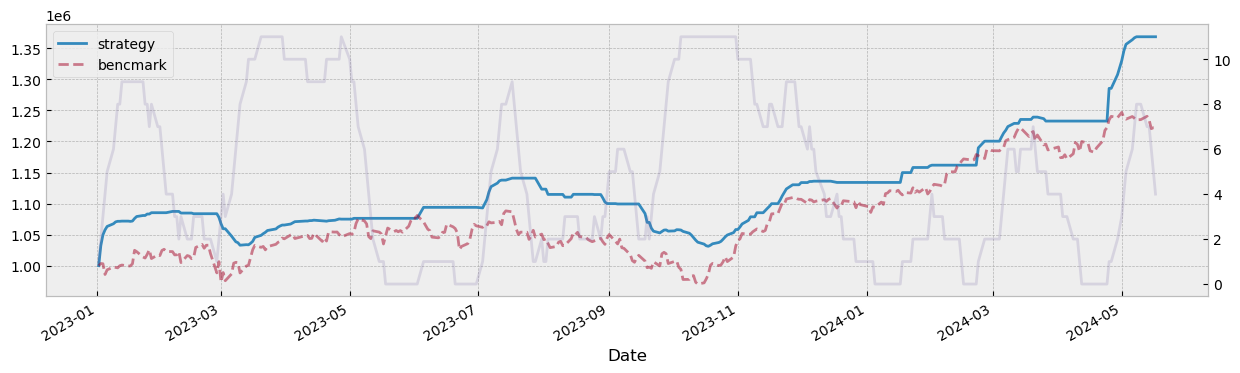

In [9]:
hold_period = 10
inital_cash = 1000000

backtest = pd.concat([price_data['open'].shift(-1), price_data['close'].shift(hold_period*-1)], axis=1).dropna()

signals = model.predict_proba(X_test[data_loaded['selected_features']])[:, 1] > data_loaded['threshold']
signals = pd.DataFrame(signals, index=X_test.index, columns=['signal']).astype(int)

backtest = backtest.join(signals).dropna()
# backtest['returns'] = ((backtest['close'] / backtest['open']) * backtest['signal'])
backtest['returns'] = (((backtest['close'] / backtest['open'] - 1) * backtest['signal']) / pd.concat([backtest.signal.shift(_) for _ in range(0, hold_period+1)], axis=1).fillna(0).sum(axis=1)).fillna(0) + 1

backtest.loc[backtest.returns == 0, 'returns'] = 1
backtest.iloc[0,3] = inital_cash

###
# backtest['returns'] = (backtest['returns'] / pd.concat([backtest.signal.shift(_) for _ in range(0, hold_period+1)], axis=1).fillna(0).sum(axis=1)).replace(np.inf,0)
###
backtest['equity_curve'] = backtest.returns.cumprod()
backtest['benchmark'] = backtest.close.pct_change().add(1).fillna(inital_cash).cumprod()

backtest['equity_curve'].plot(figsize=(15, 4), label='strategy', legend=True)
backtest['benchmark'].plot(label='bencmark', legend=True, ls='--', alpha=0.5)
pd.concat([backtest.signal.shift(_) for _ in range(0, hold_period+1)], axis=1).fillna(0).sum(axis=1).plot(secondary_y=True, ls='-', alpha=0.2, label='max open position')

In [10]:
print('strategy')
display(pd.Series(utils.Tools.backtest_performance_report(backtest['equity_curve'][backtest['signal'] == 1])))
print('benchmark')
display(pd.Series(utils.Tools.backtest_performance_report(backtest['benchmark'])))

strategy


mean_return     0.00216
volatility      0.00690
sharpe_ratio   -1.13538
max_drawdown   -0.09617
dtype: float64

benchmark


mean_return     0.00061
volatility      0.00764
sharpe_ratio   -1.22932
max_drawdown   -0.10822
dtype: float64

Feature importances

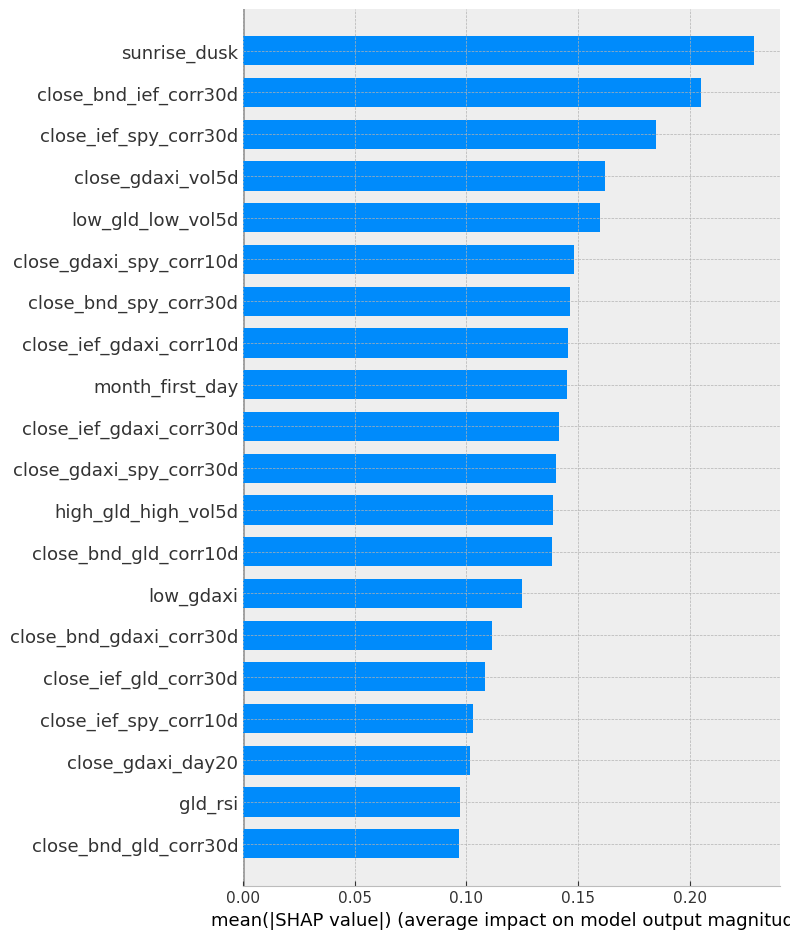

In [11]:
shap_values = shap.TreeExplainer(model).shap_values(X_train[data_loaded['selected_features']])
shap.summary_plot(shap_values, X_train[data_loaded['selected_features']], plot_type="bar")

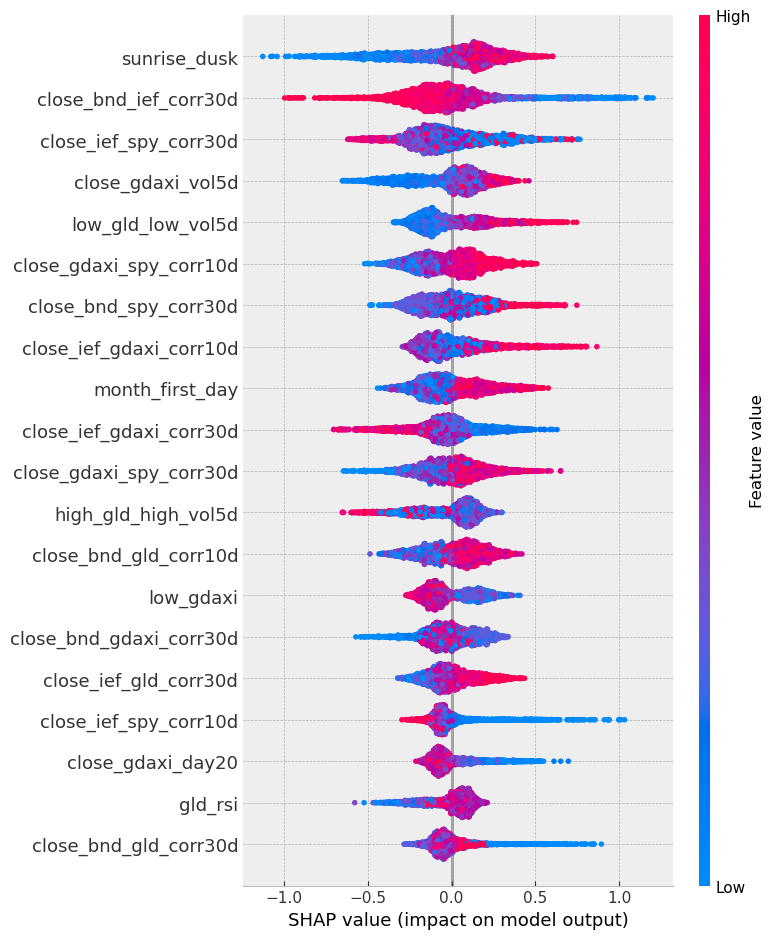

In [12]:
shap.summary_plot(shap_values, X_train[data_loaded['selected_features']])

Quantile analysis

In [13]:
signal_probas = model.predict_proba(X_test[data_loaded['selected_features']])[:, 1] 
signal_probas = pd.DataFrame(signal_probas, index=X_test.index, columns=['signal_probas'])

In [14]:
backtest = backtest.join(signal_probas)
trades = backtest[(backtest.returns != 1) & (backtest.returns != inital_cash)]

In [15]:
trades['probability_bins'] = pd.qcut(trades.signal_probas, 5, labels=range(1,6)).values.to_numpy()

In [16]:
trades.index[1:] - trades.index[:-1]

TimedeltaIndex([ '1 days',  '1 days',  '1 days',  '3 days',  '1 days',
                 '1 days',  '2 days',  '4 days',  '1 days',  '1 days',
                ...
                 '5 days',  '1 days', '30 days',  '4 days',  '2 days',
                 '1 days',  '1 days',  '3 days',  '1 days',  '1 days'],
               dtype='timedelta64[ns]', name='Date', length=146, freq=None)

In [17]:
from scipy.stats.mstats import hmean

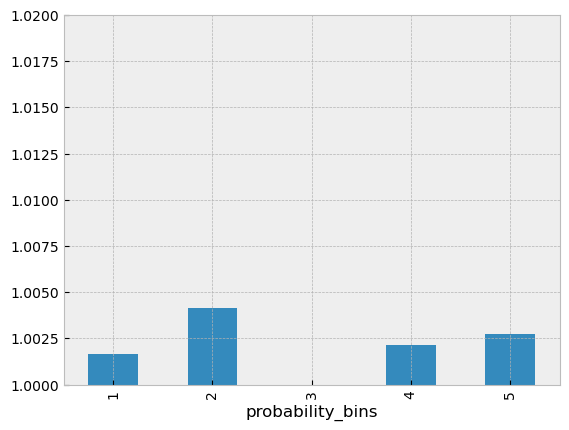

In [18]:
ax = trades.groupby('probability_bins').returns.apply(hmean).plot.bar()
ax.set_ylim(1.0, 1.02) # ax.get_ylim()[1]
plt.show()

Stress test

In [19]:
model = xgb.XGBClassifier(**data_loaded['xgb_classifier_params'])

In [20]:
subset_of_features = [x for x in data_loaded['selected_features'] if not x.startswith('sunrise') ]

In [21]:
model.fit(X_train[subset_of_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9349900034477954, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06190619805741621,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014997010109161955,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=935, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_prob = model.predict_proba(X_test[subset_of_features])

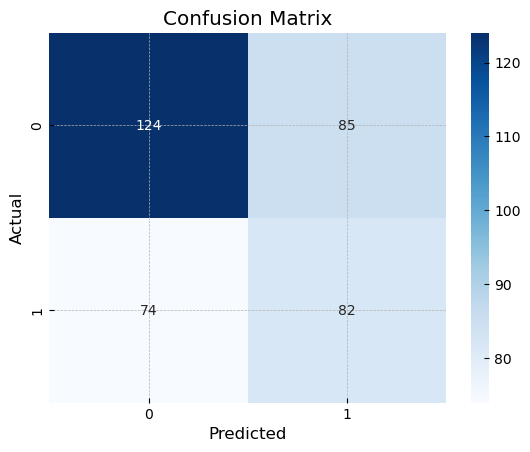

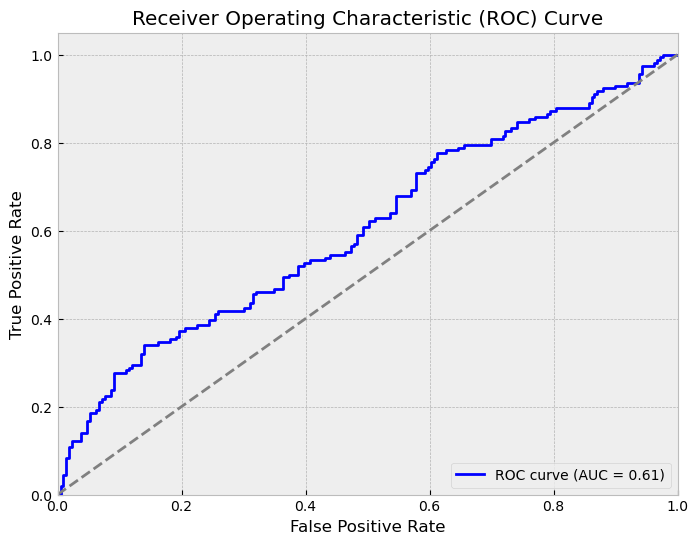

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       209
           1       0.49      0.53      0.51       156

    accuracy                           0.56       365
   macro avg       0.56      0.56      0.56       365
weighted avg       0.57      0.56      0.57       365



In [23]:
utils.Tools.performance_report(y_test, y_prob, [data_loaded['threshold']])

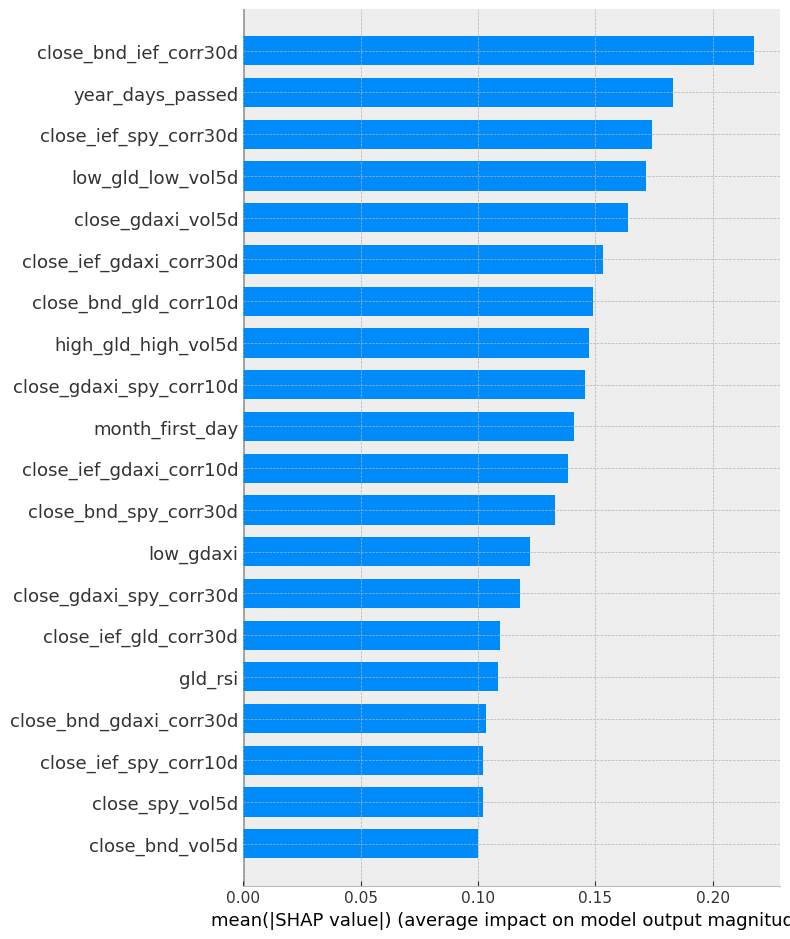

In [24]:
shap_values = shap.TreeExplainer(model).shap_values(X_train[subset_of_features])
shap.summary_plot(shap_values, X_train[subset_of_features], plot_type="bar")